# Transaction Dataset Visuals
Quick Matplotlib/Seaborn views on transaction, card, and user data. Adjust `DATA_DIR` and `N_ROWS` to fit memory/coverage needs.


In [19]:
from pathlib import Path
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")


In [20]:
# Resolve dataset location (works whether you run from repo root or this folder)
candidate_paths = [
    Path("ml/vae_annomaly_detection/dataset/dist"),
    Path("../dist"),
    Path("dist"),
]
DATA_DIR = next((p for p in candidate_paths if p.exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError(
        "Could not find dataset dist folder; tried: "
        + ", ".join(str(p) for p in candidate_paths)
    )
DATA_DIR = DATA_DIR.resolve()
DATA_DIR


PosixPath('/home/georgi/Morzio/ml/vae_annomaly_detection/dataset/dist')

In [21]:
N_ROWS = 750_000  # sample size for transactions (adjust as needed)


def parse_currency(series: pd.Series) -> pd.Series:
    cleaned = series.astype(str).str.replace(r"[^0-9.\-]", "", regex=True)
    return pd.to_numeric(cleaned, errors="coerce")


In [22]:
tx = pd.read_csv(
    DATA_DIR / "transactions_data.csv",
    nrows=N_ROWS,
    parse_dates=["date"],
    dtype={
        "id": "int64",
        "client_id": "int32",
        "card_id": "int32",
        "amount": "string",
        "use_chip": "category",
        "merchant_id": "int32",
        "merchant_city": "category",
        "merchant_state": "category",
        "zip": "float64",
        "mcc": "Int64",
        "errors": "string",
    },
)
tx["amount_value"] = parse_currency(tx["amount"])
tx["hour"] = tx["date"].dt.hour

cards = pd.read_csv(
    DATA_DIR / "cards_data.csv",
    dtype={
        "card_brand": "category",
        "card_type": "category",
    },
)

users = pd.read_csv(
    DATA_DIR / "users_data.csv",
    dtype={
        "gender": "category",
        "credit_score": "int32",
    },
)

with open(DATA_DIR / "mcc_codes.json") as f:
    mcc_map = json.load(f)

tx.shape, cards.shape, users.shape


((750000, 14), (6146, 13), (2000, 14))

In [25]:
tx.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,amount_value,hour
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,<NA>,-77.00,0
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,<NA>,14.57,0
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,<NA>,80.00,0
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,<NA>,200.00,0
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,<NA>,46.41,0


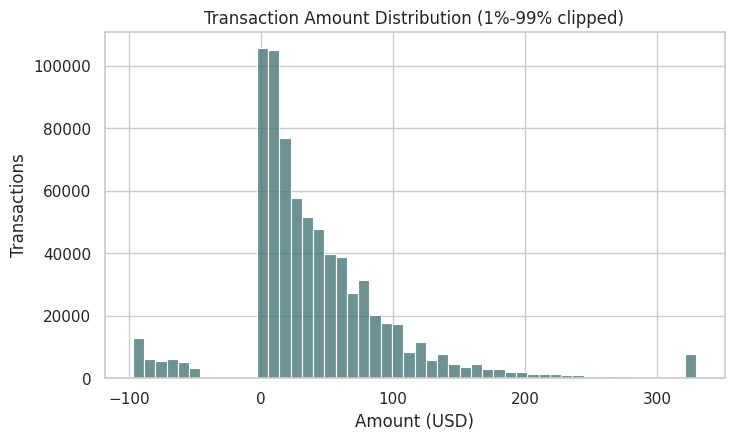

In [23]:
amounts = tx["amount_value"].dropna()
lower, upper = amounts.quantile([0.01, 0.99])
clipped = amounts.clip(lower=lower, upper=upper)

fig, ax = plt.subplots(figsize=(8, 4.5))
sns.histplot(clipped, bins=50, color="#3c6e71", ax=ax)
ax.set_title("Transaction Amount Distribution (1%-99% clipped)")
ax.set_xlabel("Amount (USD)")
ax.set_ylabel("Transactions")
plt.show()


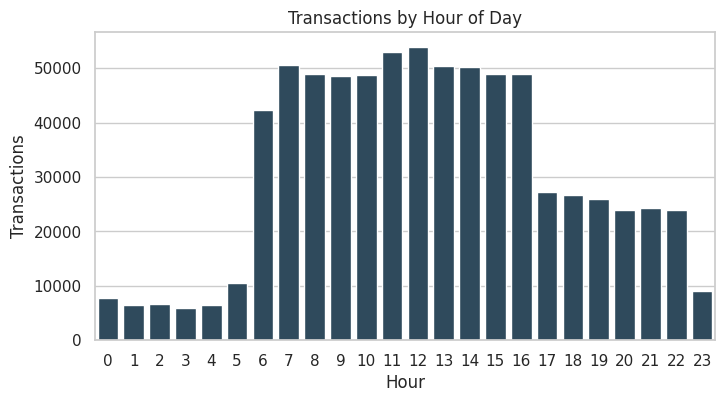

In [15]:
counts = tx["hour"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=counts.index, y=counts.values, color="#284b63", ax=ax)
ax.set_title("Transactions by Hour of Day")
ax.set_xlabel("Hour")
ax.set_ylabel("Transactions")
plt.show()


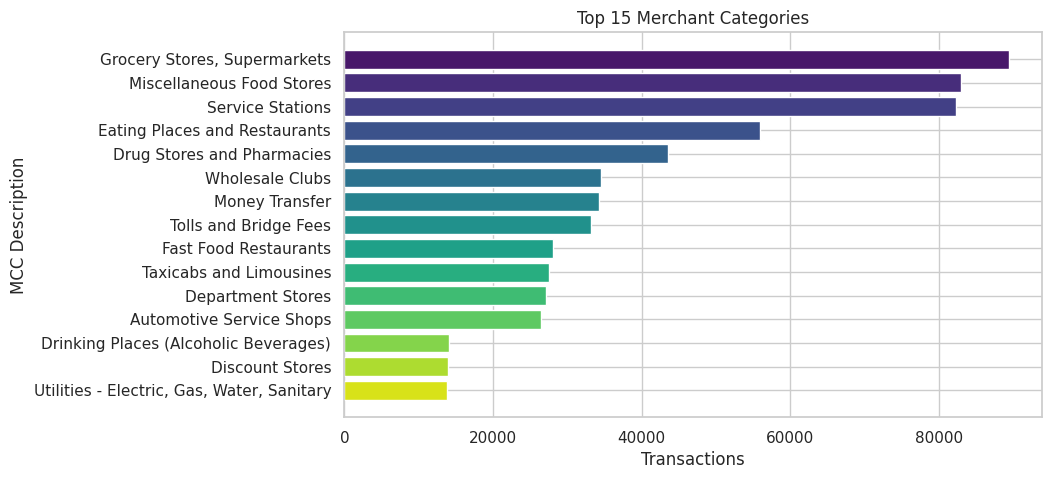

In [16]:
top_n = 15
mcc_counts = (
    tx["mcc"].dropna().astype(int).value_counts().head(top_n).rename_axis("mcc").reset_index(name="transactions")
)
mcc_counts["mcc_desc"] = mcc_counts["mcc"].astype(str).map(mcc_map).fillna("Unknown")

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(
    mcc_counts["mcc_desc"],
    mcc_counts["transactions"],
    color=sns.color_palette("viridis", len(mcc_counts)),
)
ax.set_title(f"Top {top_n} Merchant Categories")
ax.set_xlabel("Transactions")
ax.set_ylabel("MCC Description")
ax.invert_yaxis()
plt.show()


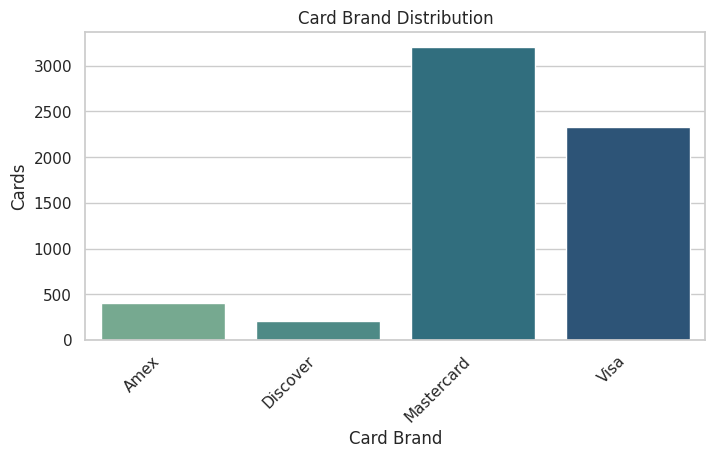

In [17]:
brand_counts = cards["card_brand"].value_counts().reset_index()
brand_counts.columns = ["card_brand", "cards"]

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=brand_counts,
    x="card_brand",
    y="cards",
    hue="card_brand",
    palette="crest",
    legend=False,
    ax=ax,
)
ax.set_title("Card Brand Distribution")
ax.set_xlabel("Card Brand")
ax.set_ylabel("Cards")
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")
plt.show()


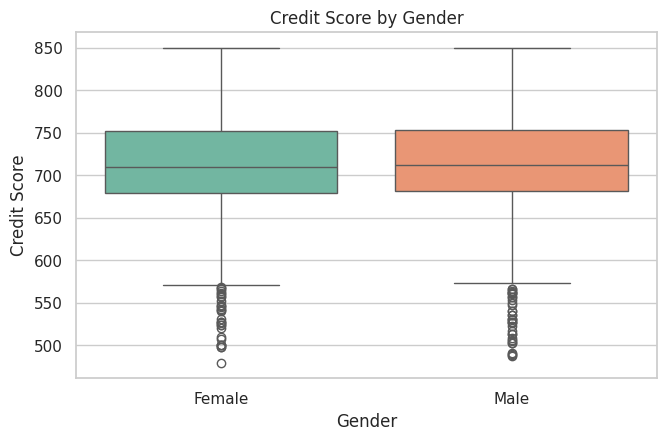

In [18]:
fig, ax = plt.subplots(figsize=(7.5, 4.5))
sns.boxplot(
    data=users,
    x="gender",
    y="credit_score",
    hue="gender",
    palette="Set2",
    legend=False,
    ax=ax,
)
ax.set_title("Credit Score by Gender")
ax.set_xlabel("Gender")
ax.set_ylabel("Credit Score")
plt.show()
